In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import rgb2hex
import data_processing as data
import svg_utils
from pathlib import Path
import glob
import os
import pandas as pd

In [2]:
data_path = Path('./data/raw/allen_HBA')

In [3]:
def read_expression_file(file_name):
    expression_df = pd.read_csv(file_name, index_col=0, header=None)
    expression_df.index.rename('probe_id', inplace=True)
    return expression_df


def read_samples_file(samples_file):
    sample_df = pd.read_csv(samples_file)
    sample_df.set_index(sample_df.index+1, inplace=True)
    sample_df.index.rename('sample_id', inplace=True)
    return sample_df


def get_probes_data(probes_file, probes_strategy='default'):
    strats = ['default', 'reannotator', 'qc_filter', 'qc_scale']
    assert probes_strategy in strats

    # depending on strategy, may merge in diff tables to update probes info
    probes_df = pd.read_csv(probes_file)

    # rename columns for consistency between adult and fetal brain datasets
    if 'probeset_name' in probes_df.columns:
        probes_df.rename(columns={'probeset_name': 'probe_name',
                                  'probeset_id': 'probe_id'}, inplace=True)
    cols = ['probe_id', 'probe_name', 'gene_symbol']
    probes_df = probes_df.loc[:, cols]

    if probes_strategy == 'reannotator':
        reannotations = get_probe_reannotations('./data/raw/gene_symbol_annotations/AllenInstitute_custom_Agilent_Array.txt')
        # drop the original gene_symbol column
        probes_df.drop('gene_symbol', axis=1, inplace=True)
        # merge in the reannotated gene_symbols
        probes_df = probes_df.merge(reannotations, on='probe_name')

    elif probes_strategy in ['qc_filter', 'qc_scale']:
        qc_filt = get_probe_qc_filter('./data/raw/gene_symbol_annotations/12864_2013_7016_MOESM8_ESM.xlsx')
        probes_df = probes_df.merge(qc_filt, left_on='probe_name', right_on='probe')
        probes_df = probes_df[probes_df.qc_filter == True]
        assert is_numeric_dtype(probes_df.m)
        assert is_numeric_dtype(probes_df.b)

        print('After getting probes_df which merged qc data, shape is {}'.format(probes_df.shape))

    probes_df.set_index('probe_id', inplace=True)

    return probes_df


def get_donor_data(donor_file_list, probes_strategy):
    # to work with both fetal and adult metadata
    probe_file_strings = ['Probes', 'rows_meta']
    samples_file_strings = ['Sample', 'columns_meta']
    expression_file_strings = ['Expression', 'expression']

    for file in donor_file_list:
        if any(string in file for string in probe_file_strings):
            probes_df = get_probes_data(file, probes_strategy=probes_strategy)
        elif any(string in file for string in samples_file_strings):
            samples_df = read_samples_file(file)
        elif any(string in file for string in expression_file_strings):
            exp_df = read_expression_file(file)
        else:
            continue

    return exp_df, samples_df, probes_df

def get_mean_expression_by_brain_area(exp_df, samples_df):
    assert(exp_df.T.shape[0] == samples_df.shape[0])

    # merge in metadata (brain area of sample)
    annotated_df = exp_df.T.merge(samples_df[['structure_name']],
                                  left_index=True, right_index=True)

    # get mean expression level for samples within a brain area
    expression_by_structure = annotated_df.groupby('structure_name').mean()
    expression_by_structure.T.index.rename('gene_symbol', inplace=True)

    return expression_by_structure.T


def get_exp_by_genes(exp_df, probes_df):
    """
    input is exp_df and probes metadata is exp_df grou
    outputped by gene_symbols and averaged
    """
    annotated_df = exp_df.merge(probes_df[['gene_symbol']],
                                left_index=True, right_index=True)

    exp_by_genes = (annotated_df.groupby('gene_symbol')
                                .mean())
                                # .drop('na'))
    return exp_by_genes

def strip_left_right(structure_name):
    brain_area_fragments = structure_name.split(',')
    clean_fragments = []

    for frag in brain_area_fragments:
        if frag.strip() not in ['left', 'right', 'Left', 'Right']:
            clean_fragments.append(frag)

    clean_structure_name = ','.join(clean_fragments)
    return clean_structure_name

In [4]:
hba_donor_folders = glob.glob(os.path.join(data_path, '*'))
all_donors = []
for i, donor_folder in enumerate(hba_donor_folders):
    print(f'Processing donor #{i+1}')
    donor_id = donor_folder.split('/')[-1].split('_')[-1]
    print(f'Donor ID: {donor_id}')
    donor_files = glob.glob(os.path.join(donor_folder, '*'))
    expression, samples, probes = get_donor_data(donor_files,
                                                 probes_strategy='default')
    donor_gene_exp = get_exp_by_genes(expression, probes)
    samples.structure_name = samples.structure_name.apply(strip_left_right)
    # this takes mean of gene expression from different brain structures
    # an alternative way to try doing it is by concatenating all samples (from all donors) 
    # and average the final values
    exp_by_brain_area = get_mean_expression_by_brain_area(donor_gene_exp, samples)
    donor_expression  = exp_by_brain_area.T
    all_donors.append(donor_expression)

Processing donor #1
Donor ID: donor10021
Processing donor #2
Donor ID: donor9861
Processing donor #3
Donor ID: donor14380
Processing donor #4
Donor ID: donor15697
Processing donor #5
Donor ID: donor15496
Processing donor #6
Donor ID: donor12876


In [5]:
all_brain_areas = pd.concat(all_donors)

In [6]:
exp_by_area = all_brain_areas.groupby('structure_name').mean()

In [7]:
exp_by_area.shape

(232, 29131)

In [8]:
# there are 232 expression values for GABRA5 
# need to create a lookup table that 
exp_by_area.loc[:, 'GABRA5'].reset_index().rename(columns={'structure': 'expression', 'structure_name': 'structure'})

,structure,GABRA5
0,CA1 field,9.460005
1,CA2 field,9.724320
2,CA3 field,9.069379
3,CA4 field,8.384222
4,"Crus I, lateral hemisphere",1.832068
5,"Crus I, paravermis",1.887136
6,"Crus II, lateral hemisphere",1.795684
7,"Crus II, paravermis",1.722494
8,Edinger-Westphal nucleus,4.455971
9,Heschl's gyrus,7.460796


In [9]:
# %load modify_svg.py
import data_processing as data
import HBA_analysis as hba
import svg_utils
import glob
from pathlib import Path


# define the SVGs files you want to modify


# inputs
svg_dir = Path('./data/svg')
human_diagram = svg_dir / 'human_diagram.svg'
#adult_dir = svg_dir / 'slices' / 'adult'

# define output directory
figures_dir = Path('./figures/GABRA5')
figures_dir.mkdir(exist_ok=True)



In [10]:
def make_expression_lookup(exp_by_area, gene_symbol='GABRA5'):
    # modify the default ontology to remove left/right from structure names
    ontology_df = pd.read_csv('./data/raw/allen_HBA/normalized_microarray_donor10021/Ontology.csv')
    # name column to be the same as fetal ontology
    ontology_df['structure_name'] = ontology_df.name.apply(data.strip_left_right)
    
    # create dicts that map from sID to structure names and inverse
    sID_to_brainstructure = ontology_df.set_index('id').loc[:, 'structure_name'].to_dict()
    brainstructure_to_sID = {}
    for k, v in sID_to_brainstructure.items():
        brainstructure_to_sID[v] = brainstructure_to_sID.get(v, [])
        brainstructure_to_sID[v].append(k)

    # map sIDs to results table
    results = exp_by_area.loc[:, gene_symbol].reset_index().rename(columns={'structure': 'expression', 'structure_name': 'structure'})
    #results = hba.generate_stats_table(exp_df, gene_list)
    #results = results.reset_index()
    #results = results.rename(columns={'index': 'structure'})
    results['id'] = results.structure.map(brainstructure_to_sID)

    # expand rows where there are multiple sIDs for each structure, then merge results
    expression_lookup = results.set_index('structure').id.apply(pd.Series).stack().reset_index(level=1, drop=True)
    #HBA_lookup = HBA_lookup.reset_index(name='id').merge(ontology_df[['id', 'parent_structure_id']], on='id')
    expression_lookup = expression_lookup.reset_index(name='id').merge(ontology_df[['id']], on='id')
    expression_lookup = expression_lookup.merge(results.drop('id', axis=1), on='structure')

    return expression_lookup    

In [11]:
expression_lookup = make_expression_lookup(exp_by_area)

In [12]:
expression_lookup.rename(columns={'GABRA5': 'expression'}, inplace=True)

In [13]:
expression_lookup.head()

,structure,id,expression
0,CA1 field,12892,9.460005
1,CA1 field,4254,9.460005
2,CA1 field,4263,9.460005
3,CA2 field,12893,9.724320
4,CA2 field,4255,9.724320


In [14]:
## this is probably unneeded
def convert_to_hex(values, cmap, norm):
    # helper to be applied on lookup table expression values
    cmap = plt.cm.get_cmap(cmap)
    color = cmap(norm(values))
    hex_color = rgb2hex(color)
    
    return hex_color

In [15]:
# probably do not need to add hex color into lookup table
# generate column with hex colour based off of range of expression values
norm = mpl.colors.Normalize(vmin=min(expression_lookup.expression), vmax=max(expression_lookup.expression))
expression_lookup['hex_color'] = expression_lookup.expression.apply(convert_to_hex, cmap='viridis', norm=norm)

In [16]:
expression_lookup.head()

,structure,id,expression,hex_color
0,CA1 field,12892,9.460005,#eae51a
1,CA1 field,4254,9.460005,#eae51a
2,CA1 field,4263,9.460005,#eae51a
3,CA2 field,12893,9.724320,#fde725
4,CA2 field,4255,9.724320,#fde725


## After creating expression lookup
1. get sIDS in SVG
2. get_expression_for_sIDs()
3. modify_structure_color()

In [17]:
import json
import os
import requests

def get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10):
    if os.path.exists(json_file):
        with open(json_file) as data_file:
            ontology = json.load(data_file)
    else:
        query_url = "http://api.brain-map.org/api/v2/structure_graph_download/{}.json".format(graph_id)
        r = requests.get(query_url)
        response = r.json()
        ontology = response['msg'][0]
        # dump out the ontology to a file
        with open(json_file, 'w') as outfile:
            json.dump(ontology, outfile)

    return ontology

In [18]:
import xml.etree.ElementTree as ET


def find_structure(self, attr, value):
    # function to find structure in ontology by attribute
    if self[attr] == value:
        return self
    else:
        for child in self['children']:
            match = find_structure(child, attr, value)
            if match:
                return match


def get_sIDs_in_SVG(svg_filename, ontology):
    # function to parse SVG and return a dict with sID as key and value is structure_name
    ns = {'svg':'http://www.w3.org/2000/svg'}
    structures_names = {}

    with open(svg_filename, 'r') as svg:
            doc = ET.parse(svg)
            root = doc.getroot()

            for elem in root.iter():
                # if this is path element and it has a structure_id
                # add structure_id to structures dictionary if it doesn't already exist
                if elem.tag == '{%s}%s' % (ns['svg'], 'path'):
                    if 'structure_id' in elem.attrib:
                        s_id = int(elem.attrib['structure_id'])
                        # is there a need for structures_names dict? would a list of sIDs suffice?
                        # could remove the need for ontology in the function if simply append s_id to a list
                        if s_id not in structures_names:
                            srec = find_structure(ontology, 'id', int(s_id))
                            structures_names[s_id] = srec['name']
    return structures_names


In [19]:
ontology = get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10)

In [20]:
svg_sIDs = get_sIDs_in_SVG(human_diagram, ontology)

In [21]:
import numpy as np

def find_children_sID(self, attr, value):
    # function to find structure IDs of the children of a given structure
    children_sID = []
    reduced_onto = find_structure(self, attr, value)
    for child in reduced_onto['children']:
        children_sID.append(child['id'])
    return children_sID


## modified previous rollup function to use expression values instead of AUC values

def roll_up(sID_list, ontology, expression_lookup, exp_vals=None):
    if exp_vals is None:
        exp_vals = []
    for sID in sID_list:
        # if the structure with sID is found in HBA_lookup
        if expression_lookup[expression_lookup.id == float(sID)].shape[0] > 0:
            #value = float(expression_lookup[expression_lookup.id == float(sID)].loc[:,'expression'])
            value = float(expression_lookup[expression_lookup.id == sID].loc[:,'expression'])
            exp_vals.append(value)
        elif len(find_children_sID(ontology, 'id', sID)) > 0:
            # the sID was not found in the results table
            # get a list of sIDs of the children of the structure of interest
            children_sIDs = find_children_sID(ontology, 'id', sID)
            roll_up(children_sIDs, ontology, expression_lookup, exp_vals)
            #print(f'sID:{sID} not found in table, rolling up values from children structures {children_sIDs}')
        else:
            # the structure was not found in HBA_lookup, nor were any of its children
            # get the values of parent structure

            # get parent sID
            structure_info = find_structure(ontology, 'id', sID)
            parent_sID = structure_info['parent_structure_id']
            print(f'sID: {sID} not found in lookup, getting values from parent: {parent_sID}')
            # get AUC val for that parent sID
            try:
                value = float(expression_lookup[expression_lookup.id == float(parent_sID)].loc[:,'expression'])
                exp_vals.append(value)
            except TypeError:
                print('No children to roll-up AUC values or parent to inherit AUC val from for sID: {}'.format(sID))
                #continue
                 
    return exp_vals


def get_exp_vals_for_sIDs(sIDs, ontology, expression_lookup):
    exp_vals = {}

    for sID in sIDs:
        children_exp_vals = roll_up([sID], ontology, expression_lookup)
        exp_vals[sID] = np.mean(children_exp_vals)

    return exp_vals

In [22]:
sID_exp_map = get_exp_vals_for_sIDs(svg_sIDs.keys(), ontology, expression_lookup)

sID: 9625 not found in lookup, getting values from parent: 9624
No children to roll-up AUC values or parent to inherit AUC val from for sID: 9625
sID: 9626 not found in lookup, getting values from parent: 9624
No children to roll-up AUC values or parent to inherit AUC val from for sID: 9626
sID: 9205 not found in lookup, getting values from parent: 9204
No children to roll-up AUC values or parent to inherit AUC val from for sID: 9205
sID: 9212 not found in lookup, getting values from parent: 9211
No children to roll-up AUC values or parent to inherit AUC val from for sID: 9212


In [23]:
import math

def convert_vals_to_hex(sID_val_map, cmap='viridis', generate_cbar=False): #'bwr'
    #centered_vals = np.abs(np.asarray(list(sID_AUC_map.values())) - 0.5)
    #drop nans
    #centered_vals = centered_vals[~np.isnan(centered_vals)]
    #extreme_val = max(centered_vals)
    #extreme_val = max(np.abs(np.asarray(list(sID_AUC_map.values())) - 0.5))

    norm = mpl.colors.Normalize(vmin=min(sID_val_map.values()) , vmax=max(sID_val_map.values()))
    color_map = plt.cm.get_cmap('{}'.format(cmap))
    sID_hex_map = {}
    for key, exp_value in sID_exp_map.items():
        #print('AUC: {} and normed: {}'.format(AUC_value, norm(AUC_value)))
        #normalized_value = norm(AUC_value)
        if math.isnan(exp_value):
            colour = '#FFFFFF'
        else:
            colour = color_map(norm(exp_value))

        sID_hex_map[key] = rgb2hex(colour)

    if generate_cbar:
        fig, ax = plt.subplots(figsize=(1, 8))
        cbar = mpl.colorbar.ColorbarBase(ax, cmap=color_map, norm=norm)
                                 #orientation='horizontal')
        cbar.set_label('Expression log2 intensity', size=12)

        return sID_hex_map, fig

    return sID_hex_map


from bs4 import BeautifulSoup

def modify_structure_color(input_svg_file, sID_val_map, output_file, cbar_file=None):
    # function to modify the colour of a structure in the SVG
    with open(output_file, 'w') as outfile, open(input_svg_file, 'r') as infile:
        # parse the svg file
        soup = BeautifulSoup(infile, 'xml')

        if cbar_file:
            sID_hex_map, cbar = convert_vals_to_hex(sID_val_map, generate_cbar=True)
            #fig.savefig(fname='./figures/colorbar.svg', format="svg")
            print(f'saving colourbar to: {cbar_file}')
            cbar.savefig(filename=cbar_file)

        else:
            sID_hex_map = convert_vals_to_hex(sID_val_map)

        # searches svg file for descendants with the structure_id of interest
        for sID in sID_hex_map:

            for desc in soup.descendants:
                try:
                    attributes = desc.attrs
                    try:
                        # need a special rule for white matter of forebrain
                        if int(attributes['structure_id']) == 9219: # 9219 = sID of telencephalic whitematter
                            attributes['style'] = 'stroke:black;fill:{}'.format('#FFFFFF') #FFC0CB
                        if int(attributes['structure_id']) == sID:
                            #print("found structure of interest: ", sID)
                            #print('structure_id: ', desc['structure_id'])
                            #print(attributes['style'])
                            attributes['style'] = 'stroke:black;fill:{}'.format(sID_hex_map[sID])
                            #print('colouring in with: ', attributes['style'])
                            #print()
                        else:
                            continue
                    except (KeyError, AttributeError):
                        #print('no attributes for this descendant:', desc)
                        continue
                except AttributeError:
                    #print('no stucture attributes for this descendant:', attributes)
                    continue
        print(f'Writing modified svg to {output_file}')
        outfile.write(str(soup))
        #return outfile

In [45]:
modify_structure_color(input_svg_file=human_diagram, sID_val_map=sID_exp_map, output_file='GABRA5.svg', cbar_file='GABRA5_legend.svg')

saving colourbar to: GABRA5_legend.svg
Writing modified svg to GABRA5.svg


In [25]:
sID_hex_map, cbar = convert_vals_to_hex(sID_val_map=sID_exp_map, cmap='viridis', generate_cbar=True)

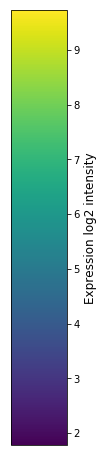

In [26]:
cbar

In [27]:
sID_exp_map

{4010: 7.175775158356251,
 4021: 7.706519505887698,
 4028: 7.4215774124042255,
 4038: 7.551385144590597,
 4041: 7.495124297536298,
 4044: 7.617225268846919,
 4047: 7.9102128653686945,
 4050: 7.887785095030082,
 4053: 7.830979188990402,
 4056: 8.058210907716099,
 4059: 7.603661713889976,
 4062: 8.178274915957044,
 4065: 8.274378178562495,
 4068: 8.748001101648708,
 4071: 7.0644054011865025,
 4078: 7.824600727914226,
 4085: 6.986863385037216,
 4096: 7.003321738039876,
 4104: 7.379635215729816,
 4111: 7.237851883209373,
 4118: 7.1299277987370235,
 4125: 7.241366016700198,
 4133: 7.5040237698580246,
 4140: 7.606695175946344,
 4147: 7.755863999989646,
 4156: 8.020551087256822,
 4165: 7.4607958977472535,
 4168: 7.339888084542438,
 4171: 7.274358329156806,
 4174: 8.05566864645924,
 4177: 7.894219070865401,
 4181: 6.305029709381152,
 4186: 6.410463212717964,
 4187: 6.256269591127502,
 4193: 6.597185468898162,
 4194: 6.305123370385836,
 4198: 7.193707821936487,
 4205: 6.844309475381066,
 4212: 

In [30]:
# modify the default ontology to remove left/right from structure names
ontology_df = pd.read_csv('./data/raw/allen_HBA/normalized_microarray_donor10021/Ontology.csv')
# name column to be the same as fetal ontology
ontology_df['structure_name'] = ontology_df.name.apply(data.strip_left_right)

# create dicts that map from sID to structure names and inverse
sID_to_brainstructure = ontology_df.set_index('id').loc[:, 'structure_name'].to_dict()
brainstructure_to_sID = {}
for k, v in sID_to_brainstructure.items():
    brainstructure_to_sID[v] = brainstructure_to_sID.get(v, [])
    brainstructure_to_sID[v].append(k)


In [35]:
final_table = pd.Series(sID_exp_map).reset_index(name='expression').rename(columns={'index': 'sID'})

In [37]:
final_table['structure'] = final_table.sID.map(sID_to_brainstructure)

In [43]:
final_table.sort_values('expression', ascending=False).to_csv('./GABRA5_expression-HBA.csv', index=None)

In [42]:
# to get the expression values in the 232 aggregated brain areas
expression_lookup.drop(['id', 'hex_color'], axis=1).drop_duplicates().shape

(232, 2)